# **1 ИМПОРТ БИБЛИОТЕК**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import mannwhitneyu

# **2 ИМПОРТ ДАННЫХ**

In [36]:
df = pd.read_csv('D:\mifi\myvenv\MLOPS\marketing_AB.csv', index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


## **2.1 ИССЛЕДОВАНИЕ ДАННЫХ**

### **Форма датасета**

In [37]:
print(f'Количество строк: {df.shape[0]}, количество столбцов: {df.shape[1]}')

Количество строк: 588101, количество столбцов: 6


### **Словарь данных:**

**user id:** Идентификатор пользователя (уникальный).

**test group:** Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.

**converted:** Если человек купил продукт, то True, иначе False.

**total ads:** Количество рекламы, увиденной человеком.

**most ads day:** День, в который человек увидел наибольшее количество рекламы.

**most ads hour:** Час дня, в который человек увидел наибольшее количество рекламы.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


### **Анализ пользователей**

Проанализируем пользователей: Есть ли среди них те, кто попали в обе тестовые группы?

In [39]:
intersection_users = list(set(df[df['test group'] == 'ad']['user id'].values) & set(df[df['test group'] == 'psa']['user id'].values))
print('Кол-во пользователей, попавших в обе группы:', len(intersection_users))

Кол-во пользователей, попавших в обе группы: 0


Проанализируем количество уникальных пользователей

In [45]:
df['user id'].nunique()

588101

Количество пользоветелей совпадает с количеством уникальных

### **Структурный анализ**
Посмотрим на графиках распределение максимального показа рекламы по дням недели и часам по группам.

In [40]:
# фильтруем данные группы ad
ad_data = df[df['test group'] == 'ad']
# фильтруем данные группы psa
psa_data = df[df['test group'] == 'psa']

### **Сравнение по most ads day**

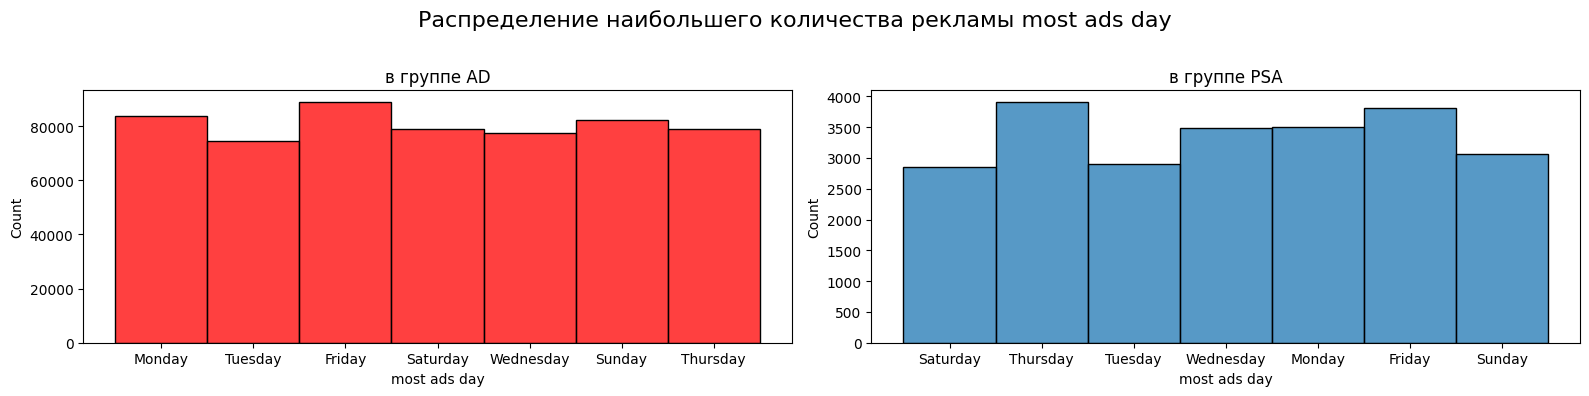

In [ ]:
# Инициализация рамкии осей
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Строим гистограммы
sns.histplot(x='most ads day', data=ad_data, ax=axes[0], color='red')
sns.histplot(x='most ads day', data=psa_data, ax=axes[1])

# Названия для графиков
fig.suptitle('Распределение наибольшего количества рекламы most ads day', fontsize=16)
axes[0].set_title('в группе ad');
axes[1].set_title('в группе psa');
plt.tight_layout(rect=[0, 0, 1, 0.96])

### **Сравнение по most ads hour**

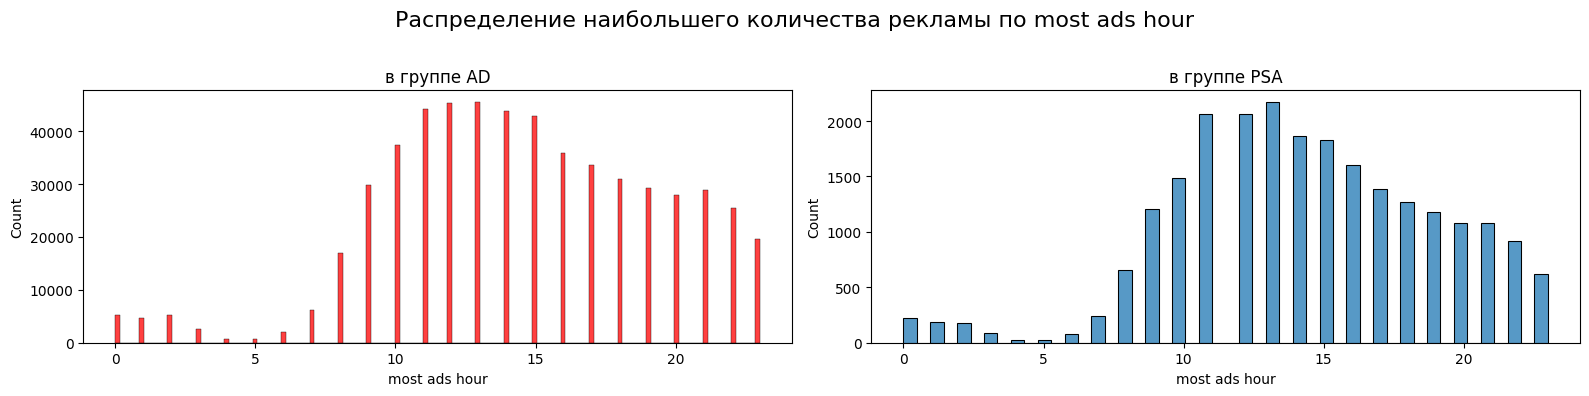

In [ ]:
# Инициализация рамкии осей
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Строим гистограммы
sns.histplot(x='most ads hour', data=ad_data, ax=axes[0], color ='red')
sns.histplot(x='most ads hour', data=psa_data, ax=axes[1])

# Названия для графиков
fig.suptitle('Распределение наибольшего количества рекламы по most ads hour', fontsize=16)
axes[0].set_title('в группе ad');
axes[1].set_title('в группе psa');
plt.tight_layout(rect=[0, 0, 1, 0.96])

У тестовых групп ad и psa не отличается распределение наибольшего количества рекламы по most ads hour, в связи с этим этот признак не является важным.

# **3 ПРЕДОБРАБОТКА ДАННЫХ**

Приведем данные к нормальному виду:

- object -> category

- bool -> int

In [42]:
# object -> category
df['test group'] = df['test group'].astype('category')
df['most ads day'] = df['most ads day'].astype('category')

# bool -> int
df['converted'] = df['converted'].astype(int)

# Демонастрация типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user id        588101 non-null  int64   
 1   test group     588101 non-null  category
 2   converted      588101 non-null  int64   
 3   total ads      588101 non-null  int64   
 4   most ads day   588101 non-null  category
 5   most ads hour  588101 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 23.6 MB


### **Удаление признаков**

In [44]:
df = df.drop(columns=['most ads day', 'most ads hour'])

# **4 РЕШЕНИЕ**

### **Посчитаем количество посещений и количество покупок по группам**

In [46]:
grouped_data = df.groupby('test group').agg({
    'user id': 'count',
    'converted': 'sum',
    'total ads': 'sum'
}).rename({'user id': 'count_of_visits', 
           'converted': 'count_of_purchases'}, axis=1)
grouped_data

C:\Users\d.bessonov\AppData\Local\Temp\ipykernel_37724\3380360057.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,count_of_visits,count_of_purchases,total ads
test group,,,
ad,564577,14423,14014701
psa,23524,420,582481


### **Конверсия и среднее количество показов рекламы**

In [ ]:
# Конверсия
grouped_data['conversion'] = grouped_data['count_of_purchases'] / grouped_data['count_of_visits'] * 100
# Среднее кол-во показов
grouped_data['mean ads'] = grouped_data['total ads'] / grouped_data['count_of_visits']

display(grouped_data)

,count_of_visits,count_of_purchases,total ads,conversion,mean ads
test group,,,,,
ad,564577,14423,14014701,2.554656,24.823365
psa,23524,420,582481,1.785411,24.761138


По полученным расчетам видим, что в группе, которой показывали рекламу, конверсия значительно выше, чем в контрольной при примерно одинаковом среднем количестве просмотренных роликов.

Проведем статистические тесты для проверки значимости полученных результатов.

### **Статистический тест для конверсии**

Сформулируем следующие гипотезы:
- Нулевая: конверсии в группах A(AD) и B(PSA) равны
- Альтернативная: конверсии в группах A(AD) и B(PSA) не равны

Используем Z-тест для пропорций.

In [48]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=grouped_data['count_of_purchases'], #число «успехов»
    nobs=grouped_data['count_of_visits'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


**Вывод:** Согласно результатом теста, при уровне значимости 0.05, мы можем утверждать, что конверсии отличаются.

### **Статистический тест для среднего количества показанной рекламы**

Посмотрим на графиках на распределение количества показанной рекламы.

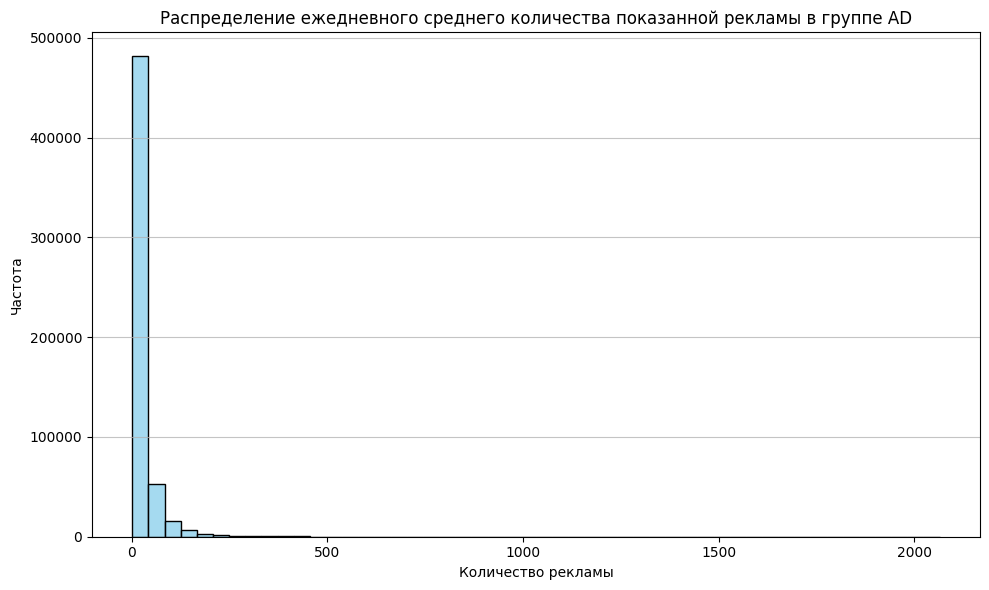

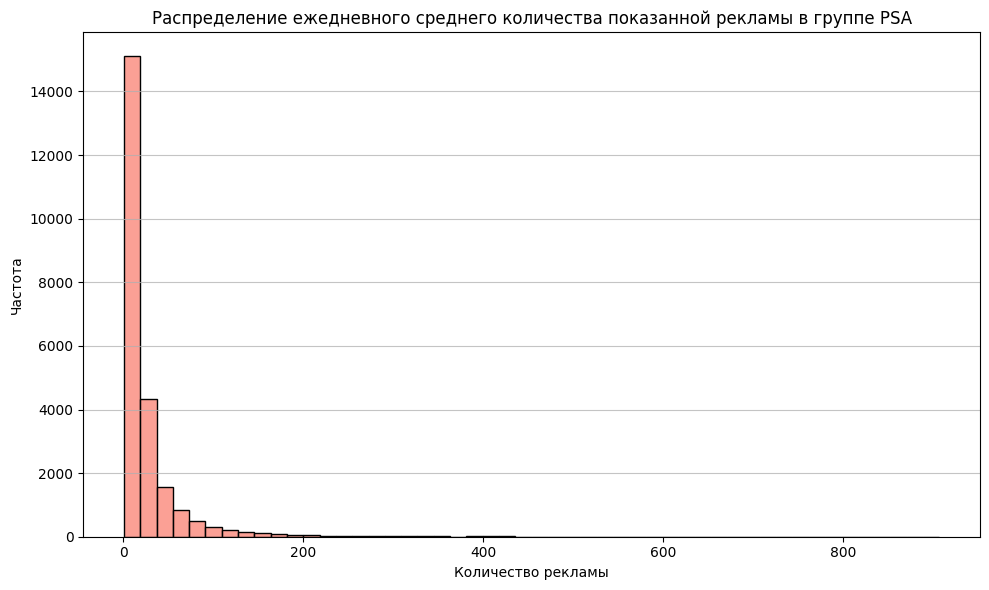

In [69]:
# График для ad_data
plt.figure(figsize=(10, 6))
sns.histplot(ad_data['total ads'], bins=50, kde=False, color='skyblue')
plt.title('Распределение ежедневного среднего количества показанной рекламы в группе AD')
plt.xlabel('Количество рекламы')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# График для psa_data
plt.figure(figsize=(10, 6))
sns.histplot(psa_data['total ads'], bins=50, kde=False, color='salmon')
plt.title('Распределение ежедневного среднего количества показанной рекламы в группе PSA')
plt.xlabel('Количество рекламы')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

На графиках видно, что распределение не выглядит нормальным, а похоже на логнормальное.

Проверим наблюдение с помощью теста Шапиро-Уилка. 

Сформулируем гипотезы:
- Нулевая: распределения количества показанных роликов в группах AD и PSA нормальны
- Альтернативная: распределения количества показанных роликов в группах AD и PSA отличаются от нормальных

In [50]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_ad = shapiro(ad_data['total ads'])
shapiro_result_psa = shapiro(psa_data['total ads'])
print('p-value группы AD', round(shapiro_result_ad.pvalue, 2))
print('p-value группы PSA', round(shapiro_result_psa.pvalue, 2))

# сравниваем полученное p-value для группы AD с уровнем значимости
if shapiro_result_ad.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе AD отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе AD является нормальным")

# сравниваем полученное p-value для группы PSA с уровнем значимости
if shapiro_result_psa.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе PSA отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе PSA является нормальным")

p-value группы AD 0.0
p-value группы PSA 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе AD отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе PSA отлично от нормального


d:\mifi\myvenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 564577.

d:\mifi\myvenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23524.



Тест подтвердил, что распределение количества показанных роликов отличается от нормального, поэтому для дальнейшей проверки воспользуемся тестом Манна-Уитни.

Сформулируем гипотезы:
- Нулевая: распределения количества показанных роликов в группах AD и PSA совпадают
- Альтернативная: распределения количества показанных роликов в группах AD и PSA различаются

In [51]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=ad_data['total ads'],
    y=psa_data['total ads'],
    alternative='two-sided',
)

print('p-value:', round(float(results.pvalue), 4))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")


p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Тест показал, что при уровне значимости 0,05 распределения в количестве показов роликов различаются.

### **Доверительный интервал для конверсии**

Напишем функцию, вычисляющую доверительный интервал для пропорций.

In [ ]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    # уровень значимости
    alpha = 1 - gamma 

    # z-критическое
    z_crit = -norm.ppf(alpha/2) 
    # погрешность
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 

    # левая (нижняя) граница
    lower_bound = x_p - eps
    # правая (верхняя) граница 
    upper_bound = x_p + eps 
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [53]:
# строим доверительный интервал для конверсии в группе AD
lower_bound_ad, upper_bound_ad  = proportion_conf_interval(
    x_p=ad_data['converted'].mean(), # выборочная пропорция
    n=ad_data['user id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе PSA
lower_bound_psa, upper_bound_psa  = proportion_conf_interval(
    x_p=psa_data['converted'].mean(), # выборочная пропорция
    n=psa_data['user id'].count() # размер выборки
)

# выводим результат
print(f'С вероятностью 95% в группе AD значение конверсии лежит в интервале между {round(float(lower_bound_ad) * 100, 2)} и {round(float(upper_bound_ad) * 100, 2)}')
print(f'С вероятностью 95% в группе PSA значение конверсии лежит в интервале между {round(float(lower_bound_psa) * 100, 2)} и {round(float(upper_bound_psa) * 100, 2)}')


С вероятностью 95% в группе AD значение конверсии лежит в интервале между 2.51 и 2.6
С вероятностью 95% в группе PSA значение конверсии лежит в интервале между 1.62 и 1.95


### **Доверительный интервал для разности конверсий**

Напишем функцию, вычисляющую доверительный интервал для разности пропорций.

In [54]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп AD и PSA
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [55]:
# размеры выборок групп AD и PSA
n = [ad_data['user id'].count(), psa_data['user id'].count()]
# выборочная пропорция групп AD и PSA
x_p = [ad_data['converted'].mean(), psa_data['converted'].mean()]

# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

# выводим результат
print(f'С вероятностью 95% разность конверсий лежит в интервале между {round(float(lower_bound) * 100, 2)} и {round(float(upper_bound) * 100, 2)}')

С вероятностью 95% разность конверсий лежит в интервале между -0.94 и -0.6


Видим, что с вероятностью 95% конверсия в группе AD будет выше, чем в группе PSA.

### **Доверительный интервал для среднего количества увиденной рекламы**

Воспользуемся функцией из библиотеки SciPy и построим доверительные интервалы для среднего количества увиденной рекламы в каждой из групп и во всей выборке.

In [56]:
mean_ad = ad_data['total ads'].mean()
std_ad = ad_data['total ads'].std()
n_ad = len(ad_data['total ads'])

# Рассчитываем стандартную ошибку
sem_ad = std_ad / np.sqrt(n_ad)

# строим доверительный интервал для среднего при неизвестном СКО
lower_ad, upper_ad = t.interval(0.95, df=n_ad-1, loc=mean_ad, scale=sem_ad)

mean_psa = psa_data['total ads'].mean()
std_psa = psa_data['total ads'].std()
n_psa = len(psa_data['total ads'])

# Рассчитываем стандартную ошибку
sem_psa = std_psa / np.sqrt(n_psa)

# строим доверительный интервал для среднего при неизвестном СКО
lower_psa, upper_psa = t.interval(0.95, df=n_psa-1, loc=mean_psa, scale=sem_psa)

mean = df['total ads'].mean()
std = df['total ads'].std()
n = len(df['total ads'])

# Рассчитываем стандартную ошибку
sem = std / np.sqrt(n)

# строим доверительный интервал для среднего при неизвестном СКО
lower, upper = t.interval(0.95, df=n-1, loc=mean, scale=sem)


print('Доверительный интервал в группе AD: {}'.format((round(float(lower_ad), 2), round(float(upper_ad), 2))))
print('Доверительный интервал в группе PSA: {}'.format((round(float(lower_psa), 2), round(float(upper_psa), 2))))
print('Доверительный интервал по всей выборке: {}'.format((round(float(lower), 2), round(float(upper), 2))))


Доверительный интервал в группе AD: (24.71, 24.94)
Доверительный интервал в группе PSA: (24.21, 25.31)
Доверительный интервал по всей выборке: (24.71, 24.93)


Видим, что доверительные интервалы довольно и близки и можем сказать, что в генеральной совокупности среднее количество показанных роликов с вероятностью 95% будет лежать в диапазоне между 24.71 и 24.93.

# **ИТОГИ**

В результате проведенного исследования, мы можем утверждать, что с вероятностью 95% проведение рекламной компании повысит конверсию на величину в диапозоне от 0,6 до 0.94.
